In [1]:
args_str = '--model=rnn_separate --num_epochs=100 --num_data_workers=8 --num_backpropagation_time_steps=10 --learning_rate=0.00003 --neuron_num_layers=3 --neuron_residual --save_all_predictions --loss=poisson --synaptic_adaptation --subset_variant=2'



In [2]:
import sys
import scipy
sys.path.append('/home/david/source/diplomka/thesis_results/evaluation/syn_adapt_10_poisson/best_models')
from execute_model import init_parser, init_model_path
from nn_model.model_executer import ModelExecuter
from nn_model.globals import  LAYER_TO_PARENT, EXCITATORY_LAYERS
# from nn_model.connection_learning import ConnectionAffine, get_features, pairwise_delta
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import matplotlib.colors as colors
from dataclasses import dataclass, field
import seaborn as sns

In [3]:
sns.set_theme(
    style="ticks",
    context="paper",
)

In [4]:
parser = init_parser()

args = parser.parse_args(args_str.replace('"', '').split())
args.model_filename = init_model_path(args)

executer = ModelExecuter(args)

executer._load_best_model()

/home/david/.cache/pypoetry/virtualenvs/neural-simulator-lOyI4ksM-py3.12/lib64/python3.12/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/david/.cache/pypoetry/virtualenvs/neural-simulator-lOyI4ksM-py3.12/lib64/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


UnpicklingError: Weights only load failed. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution.Do it only if you get the file from a trusted source. WeightsUnpickler error: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
@dataclass
class NeuralConnectionPopulation:
    layer_name_pre: str
    layer_name_post: str
    lateral: np.ndarray
    autapses: np.ndarray | None
    features: dict[str, tuple[torch.Tensor, torch.Tensor]]


In [ ]:
def diag_mask(x):
    return torch.eye(x.size(0), dtype=torch.bool, device=x.device)

In [ ]:
def get_affine_modules():   
    for idx, (layer_name, layer) in enumerate(executer.model.layers.items()):
        yield layer.rnn_cell.weights_hh
        yield layer.rnn_cell.weights_lateral


In [ ]:
@torch.no_grad()
def affine_module_to_population(x: ConnectionAffine) -> NeuralConnectionPopulation:
    lateral = x.weight()
    autapses = None
    features = get_features(x.layer_name_pre, x.layer_name_post)
    
    if x.weight.has_self_connection:
        assert lateral.shape[0] == lateral.shape[1]
        autapses = lateral.diagonal()
        mask = ~diag_mask(lateral).flatten()       

    
    lateral = lateral.cpu().detach().numpy()
    return NeuralConnectionPopulation(
        x.layer_name_pre,
        x.layer_name_post, 
        lateral,
        autapses,
        features
    )

In [ ]:
all_populations = list(map(affine_module_to_population, get_affine_modules()))

In [ ]:
translate = {
    'V1_Exc_L4':   'L4(E)',
    'V1_Inh_L4':   'L4(I)',
    'V1_Exc_L23': 'L2/3(E)',
    'V1_Inh_L23': 'L2/3(I)',
}

In [ ]:
ticks = ["π/4", "π/2", "3/4π", "π", ]

In [ ]:
l4 = [x for x in all_populations if "L4" in x.layer_name_pre.upper()]
l23 = [x for x in all_populations if "L2" in x.layer_name_pre.upper()]

In [13]:
def plot(populations, feature_to_plot:str='ori'):
    assert feature_to_plot in ('ori', 'phase')
    is_ori = feature_to_plot == 'ori'
    plt.figure(figsize=(15, 10))
    for i, population in enumerate(populations):
        features = population.features
        x = features['x']
        y = features['y']
        ori = features['ori']
        feat = features[feature_to_plot]
        dx = pairwise_delta(*x)
        dy = pairwise_delta(*y)
        # relative distance
        dist = (dx ** 2 + dy ** 2) ** 0.5
        dist = dist.cpu().detach().numpy()
        # relative orientation
        ori = pairwise_delta(*ori).cpu().detach().numpy()
        pred = population.lateral.flatten()
        if is_ori:
            x_feat = ori
        else:
            x_feat = pairwise_delta(*features['phase']).cpu().detach().numpy()
        binned = scipy.stats.binned_statistic_2d(x_feat, dist, pred, statistic='mean', bins=(151, 100))
        
        left = binned.x_edge.min()
        right = binned.x_edge.max()
        bottom = binned.y_edge.min()
        top = binned.y_edge.max()
        extent = [left, right, bottom, top]
    
    
        # sample_idx = np.random.choice(len(x), 100000)
        plt.subplot(220 + i + 1)
        xlines = np.arange(-4, 5) / 4 * np.pi
        if not is_ori:
            xlines *= 2
        for xline in xlines:
            plt.axvline(xline, color="black", linestyle=":",)

        if is_ori:
            plt.xticks(xlines, labels=["-π", "-3/4π", "-π/2", "-π/4", "0", "π/4", "π/2", "3/4π", "π"])
        else:
            plt.xticks(xlines, labels=["-2π", "-3/2π", "-π", "-π/2", "0", "π/2", "π", "3/2π", "2π"])
        norm_boundries = sorted([pred.min(), pred.max(), 0])
        # norm = colors.TwoSlopeNorm(vmin=norm_boundries[0], vcenter=norm_boundries[1],  vmax=norm_boundries[2])
        # https://stackoverflow.com/a/18696354/16273760
        cmap = 'jet'
        if 'inh' in population.layer_name_pre.lower():
            cmap += '_r'
        plt.imshow(binned.statistic.T, origin='lower', aspect='auto', interpolation="none", extent=extent, cmap=cmap, )
    
    
        # plt.xlabel('Emergent Phase Difference — No Priors')
        if is_ori:
            plt.xlabel('Orientation difference')
        else:
            plt.xlabel('Phase difference')
        plt.ylabel('Distance (cm)')
        if is_ori:
            plt.xlim(-np.pi, np.pi)
        else:
            plt.xlim(-2*np.pi, 2*np.pi)
        plt.ylim(0, dist.max())
        cbar = plt.colorbar()
        cbar.set_label('Connection Weight\n(white = no data)')
        layer_pre = population.layer_name_pre
        layer_post = population.layer_name_post
        assert LAYER_TO_PARENT[layer_pre] == LAYER_TO_PARENT[layer_pre]
        title = LAYER_TO_PARENT[layer_pre]
        def layer_to_polarity(layer):
            if layer in EXCITATORY_LAYERS:
                return 'Exc'
            return 'Inh'
        p1 = layer_to_polarity(layer_pre)
        p2 = layer_to_polarity(layer_post)
        plt.title(f"{title} {p1}->{p2}")
    plt.tight_layout()
    plt.savefig(f"connections_{title}_{feature_to_plot}.pdf", bbox_inches='tight')
    plt.show()


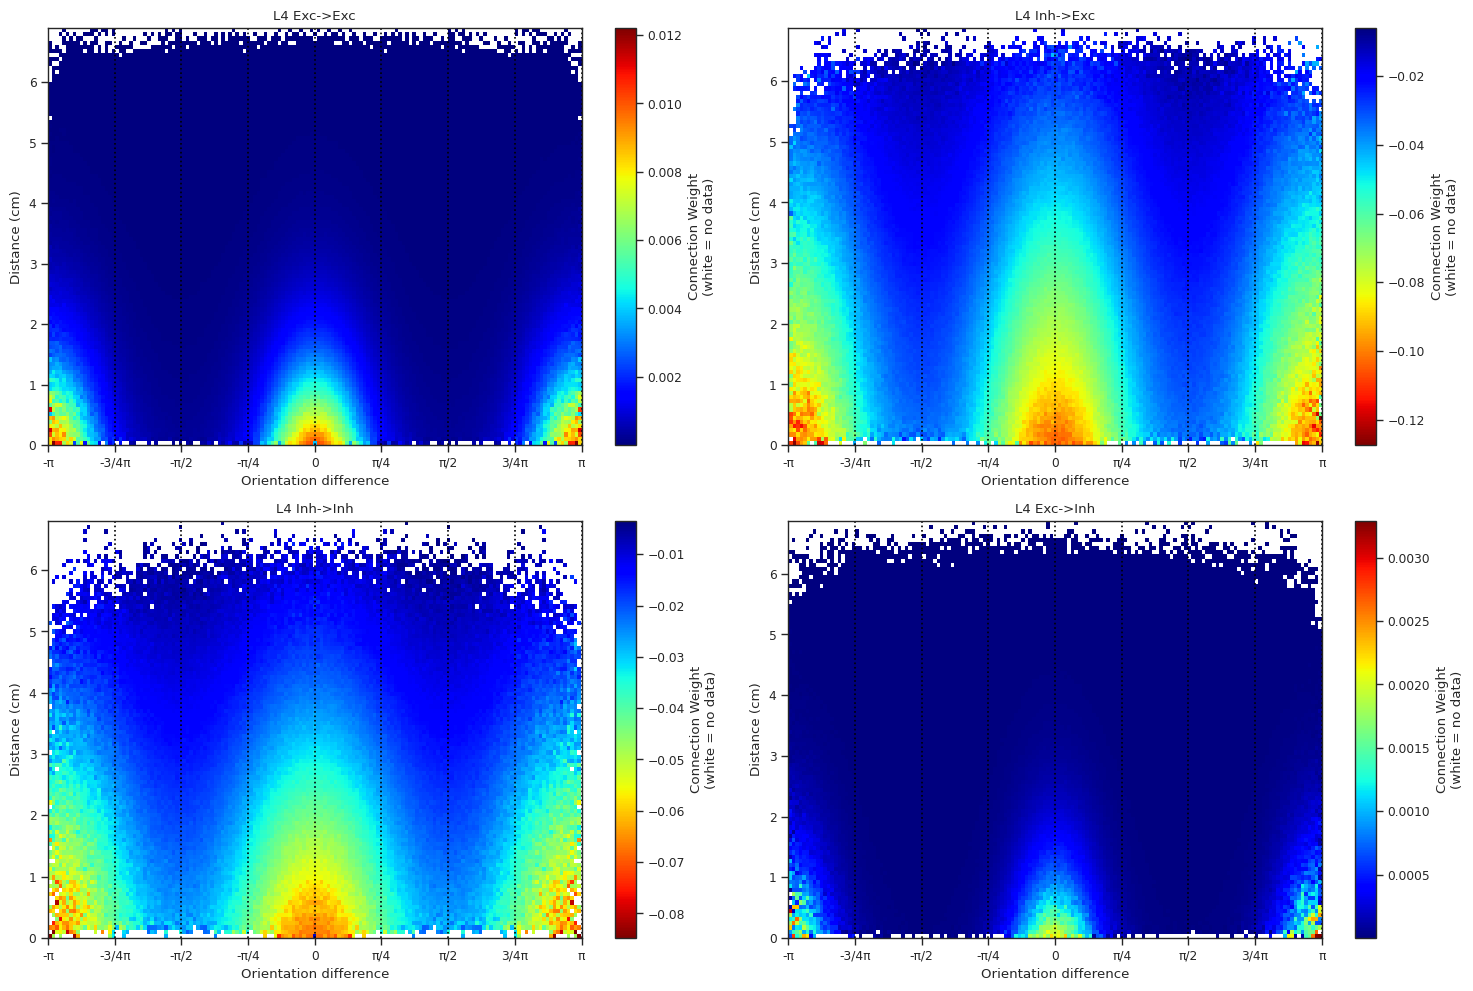

In [14]:
plot(l4)

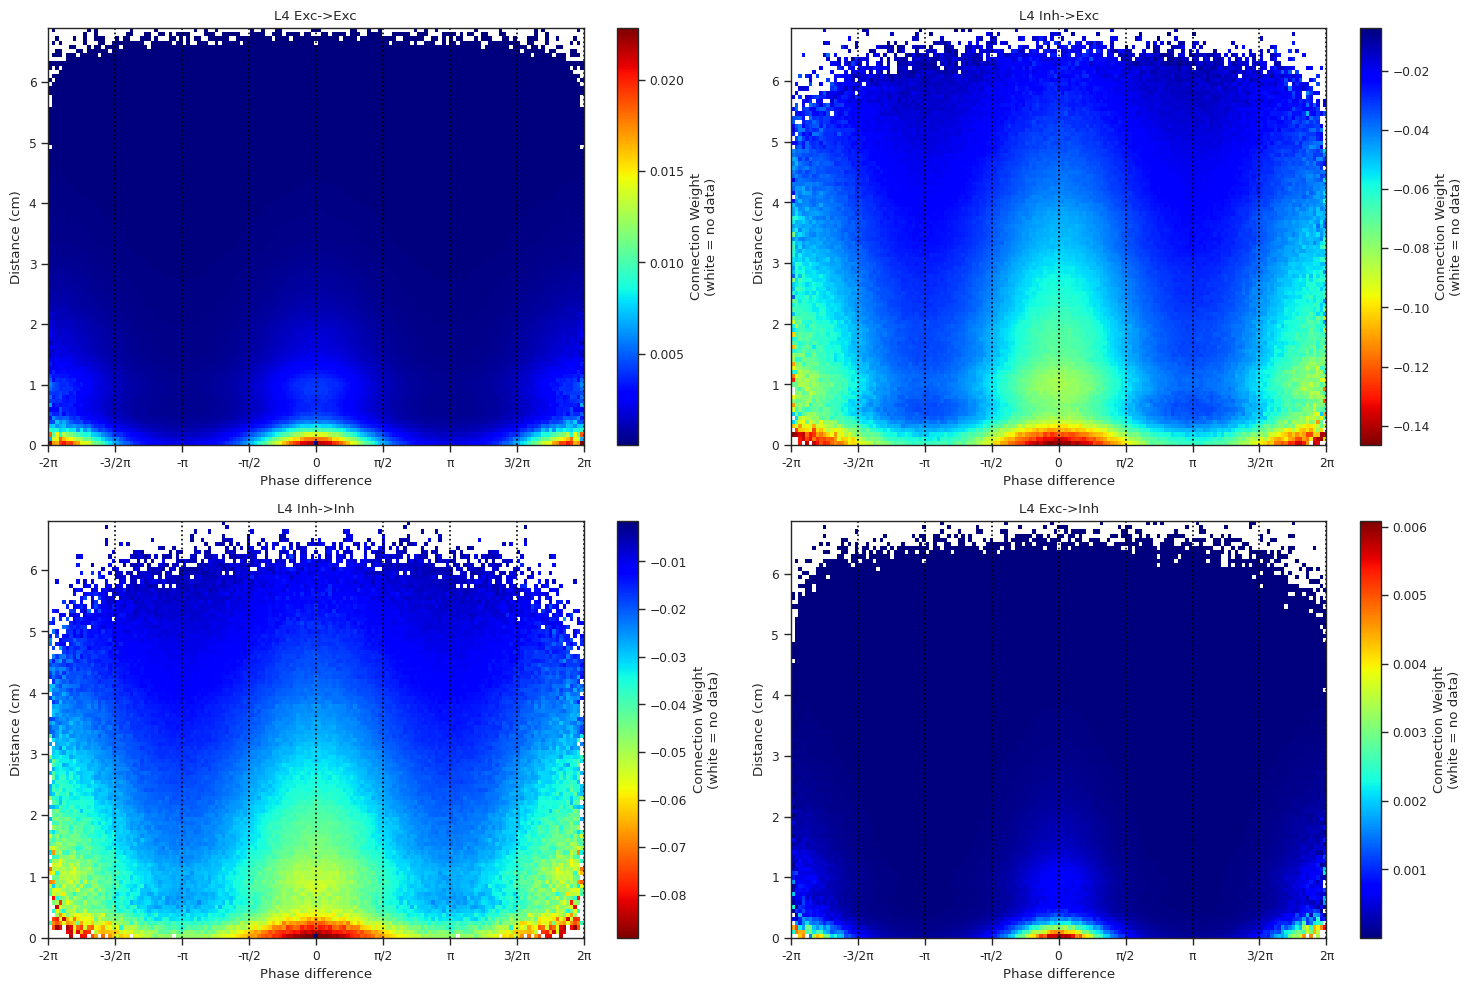

In [15]:
plot(l4, 'phase')

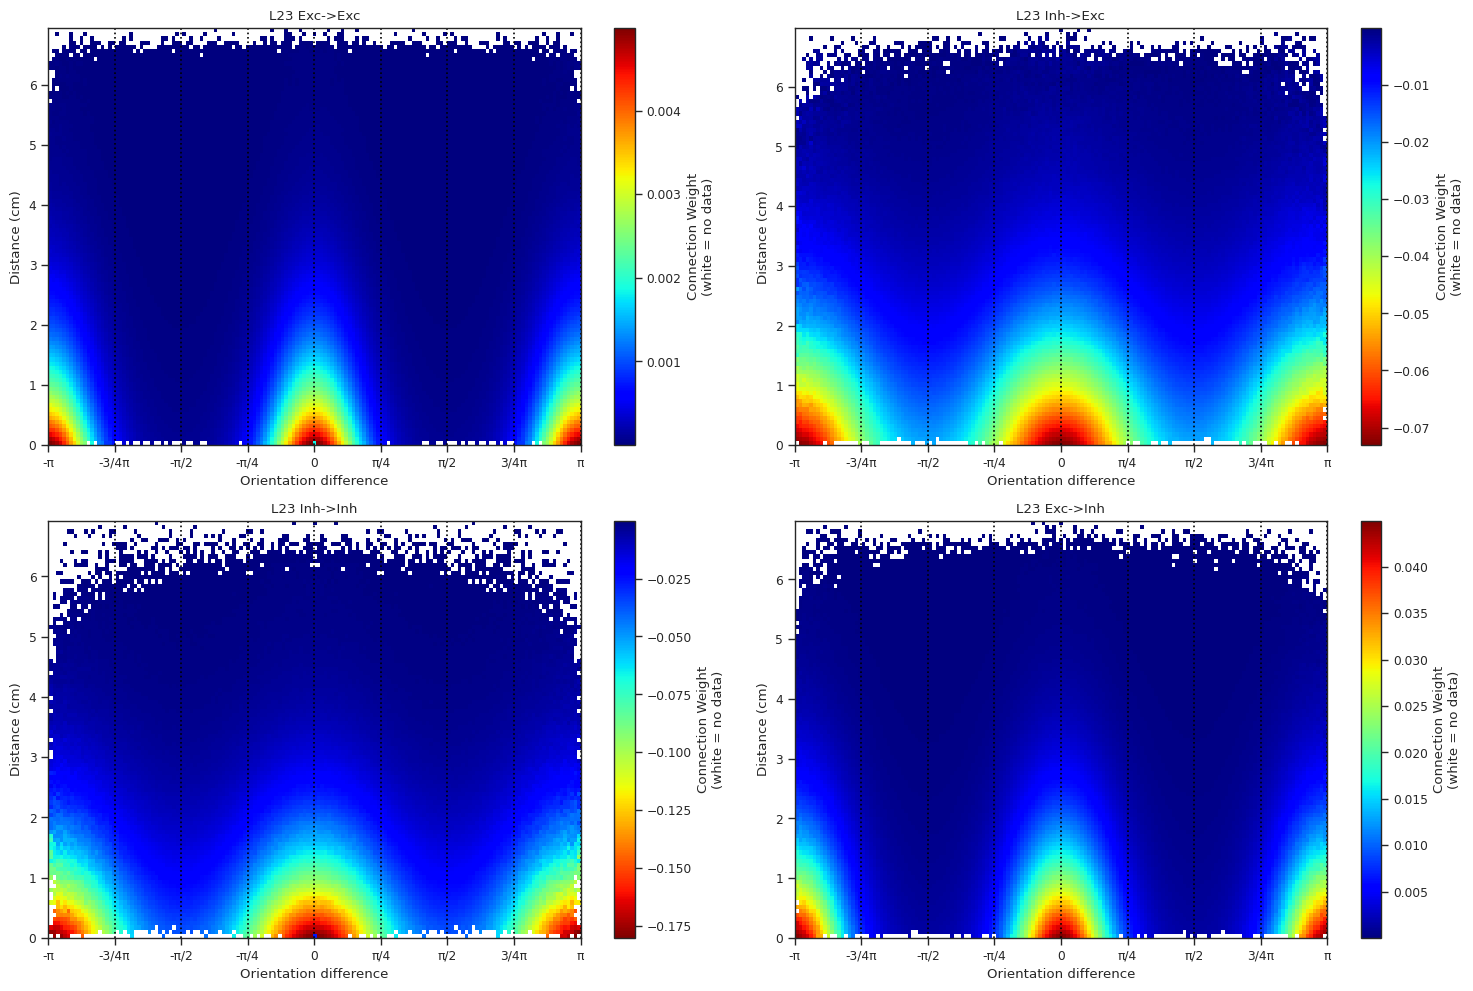

In [16]:
plot(l23)